<a href="https://colab.research.google.com/github/MDankloff/Delayed-Fairness-Project/blob/main/BAF_TryOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import random
import glob
import os
import joblib


In [2]:
!pip install aequitas #Fairness tree aequitas tool
from aequitas.group import Group # Fairness metrics
from aequitas.bias import Bias
from aequitas.fairness import Fairness

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━

In [38]:
!pip install mesa pandas scikit-learn networkx
!pip install mesa
from mesa import Model, Agent
#from mesa.time import RandomActivation

ModuleNotFoundError: No module named 'mesa.time'

# Load BAF data

Saved parquet files from csv

In [20]:
from google.colab import drive
drive.mount('/content/drive')
!cd '/content/drive/MyDrive/Supervision new/Paper#4 Delayed Fairness Project/BAF'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
base_path = '/content/drive/MyDrive/Supervision new/Paper#4 Delayed Fairness Project/BAF/parquet data'

extension = "parquet" #parquet for smaller files, csv available
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [22]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

#for better display
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

dfs = [base, variant1, variant2, variant3, variant4, variant5]

df4 = variant4 #set to preferred variant
new_df4 = df4.copy()

# Explore Data

In [23]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [24]:
#make a simplified df containing only a few features
df4_simple = df4[['fraud_bool', 'customer_age', 'credit_risk_score', 'month']]

In [25]:
df4_simple['month'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

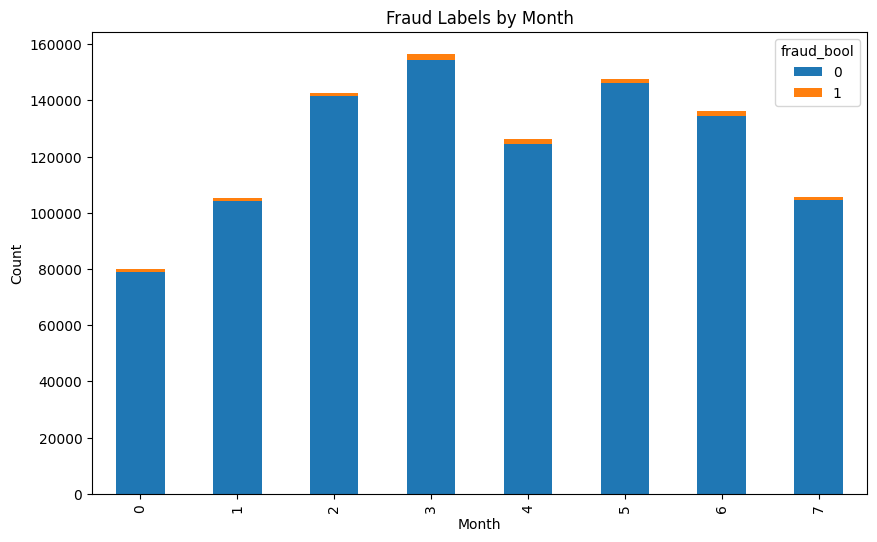

In [26]:
#fraud per month
fraud_per_month = df4_simple.groupby(['month','fraud_bool']).size().unstack()
fraud_per_month.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fraud Labels by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

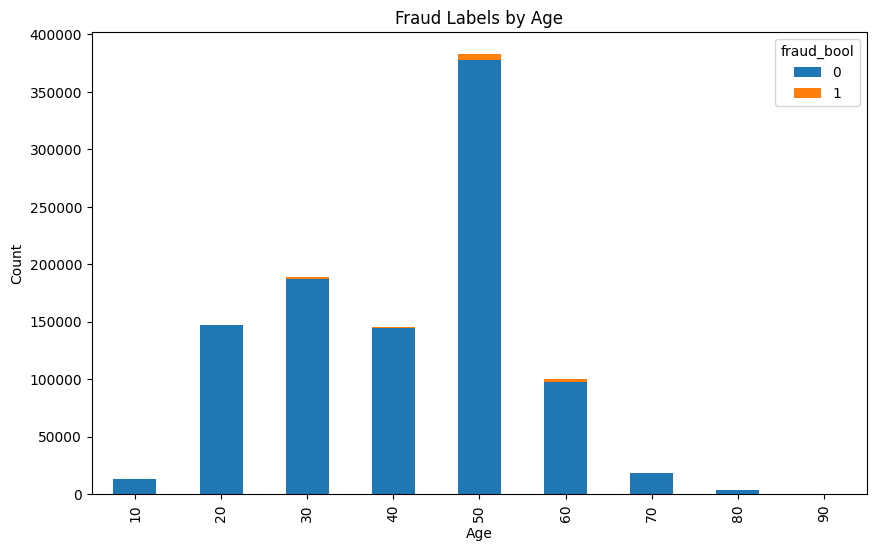

In [27]:
#fraud per age
fraud_per_age = df4_simple.groupby(['customer_age','fraud_bool']).size().unstack()
fraud_per_age.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fraud Labels by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [28]:
print(df4_simple.iloc[0])

fraud_bool             0
customer_age          30
credit_risk_score    149
month                  0
Name: 0, dtype: int64


# Random Activation

In [40]:
#Randomly orders and activates all agents for each simulation step. Could not get mesa.time
class RandomActivation:
  def __init__(self, model):
    self.model = model
    self.agents = []

    def add(self, agent):
      self.agents.append(agent)

    def step(self):
      import random
      random.shuffle(self.agents)
      for agent in self.agents:
        agent.step()

# Create demographic groups per age

In [30]:
# define age groups - according to BAF authors
df4_simple['group'] = np.where(df4_simple['customer_age'] >= 50, 'Older', 'Younger')

  # split in 2 groups
group_young = df4_simple[df4_simple['group'] == 'Younger']
group_old = df4_simple[df4_simple['group'] == 'Older']

/tmp/ipython-input-30-3919257022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_simple['group'] = np.where(df4_simple['customer_age'] >= 50, 'Older', 'Younger')


<Axes: xlabel='group'>

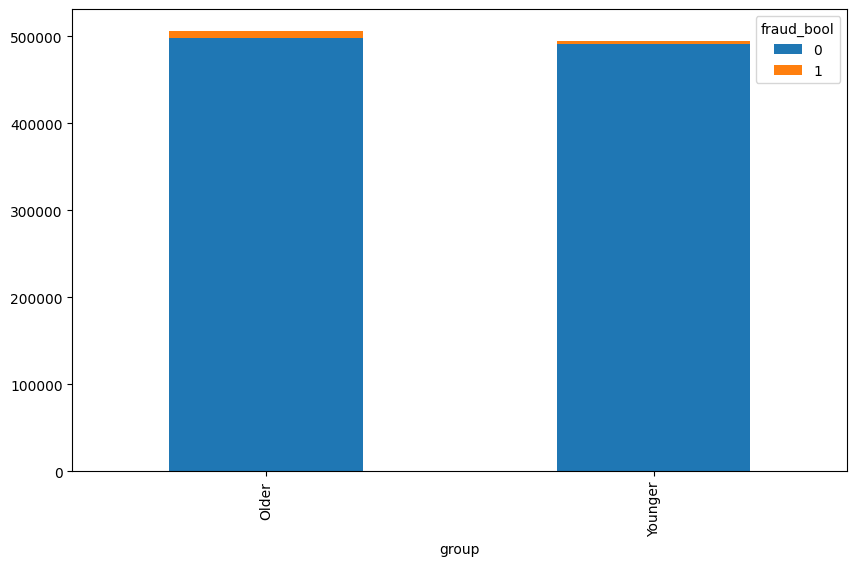

In [31]:
fraud_young_old=df4_simple.groupby(['group','fraud_bool']).size().unstack()
fraud_young_old.plot(kind='bar', stacked=True, figsize=(10, 6))

In [32]:
group_young[group_young['fraud_bool'] == 1]['fraud_bool'].count()

np.int64(2656)

In [33]:
group_old[group_old['fraud_bool'] == 1]['fraud_bool'].count()

np.int64(8374)

# Applicant Agent

In [34]:
#Representing loan applicants. They can interact, share perceptions and decide whether to apply

class ApplicantAgent(Agent):
    def __init__(self, unique_id, model, group, credit_risk_score, fraud_label): #initializing the agent
        super().__init__(unique_id, model)
        self.group = group # agents demographic group: group_young or group_old
        self.credit_risk_score = credit_risk_score #internal score of application risk
        self.fraud_label = fraud_label #whether someone is a fraudster
        self.applied = True # whether this applicant tries to apply for a loan
        self.approved = False # whether they got the loan
        self.unique_id = unique_id #unique nr or string to identify the agent
        self.model = model #overall simulation model

        self.perceived_fairness = 1.0 # something about the perceived fairness where 1.0 = full perceived fairness

#agent decides each time step whether they apply for a loan. They only apply if the perceived_fairness is above some cutoff e.g. 0,3 (which is stored in the overall_model)
    def step(self):
      self.applied = self.perceived_fairness >= self.model.fairness_threshold


# Lender Agent

In [35]:
class lenderAgent(Agent):
  def __init__(self, unique_id, model, fairness_policy): #fairness policy indictates which fairness rule to follow
    super().__init__(unique_id, model)
    self.unique_id = unique_id
    self.model = model
    self.fairness_policy = fairness_policy

  def make_decision(self, applicant):
    threshold = self.model.credit_threshold #credit score cutoff for loan approval (e.g. 0.6)
    score = applicant.credit_risk_score #the appicants predicted creditworthiness

    if self.fairness_policy == "profit": #maximize repayment likelihood
      return self.policy_profit(applicant)

    elif self.fairness_policy == "demographic_parity": #Equal Approval rates for groups
      return self.policy_demographic_parity(applicant)

    elif self.fairness_policy == "equal_opportunity":
      return self.policy_equal_opportunity(applicant)



    #elif self.fairnes_policy == "demographic_parity":
      #if applicant.group =


# Fairness policies

In [ ]:
#def profit_policy(applicant, threshold):

#def demographic_parity(group_df, approval_rate):



In [ ]:
# Demographic (statistical) Parity = Equal Approval rates for groups
def demographic_parity(df, approval_rate):
  num_approved = int(len(df) * approval_rate)
  return group.sample(n=num_approved)

def max_utility(df, approval_rate):
  group['predicted_probability'] = model.predict_proba(group[['relevant_features']])[:, 1] #add column with predicted probabilities

    # Select applications where predicted probability is above the threshold:
  approved = group[group['predicted_probability'] >= threshold]
  return approved

In [ ]:
def apply_fairness_policy(df, policy, threshold):
    if policy == "demographic_parity":
        return demographic_parity(df, threshold)
    else:
        return max_utility(df, threshold)


# Loan model

In [ ]:
class LoanModel:
  def __init__(self, df_data, fairness_policy):
    self.schedule = RandomActivation(self)
    self.fairness_policy = fairness_policy
    self.credit_threshold = 0.6 #
    self.fairness_threshold = 0.3

# Simulate

In [ ]:
def main(df):

  # apply fairness policy
  policy = "demographic_parity"
  approval_rate = 0.3
  approved_a = apply_fairness_policy(group_a, policy, threshold= approval_rate)
  approved_b = apply_fairness_policy(group_b, policy, threshold = approval_rate)

  # combine groups
  approved = pd.concat([approved_a, approved_b])